In [1]:
# coding: utf-8
import time
import os, PIL
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader,  random_split
import pathlib

# 使用gpu训练
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

# 打印显卡信息，确认GPU可用
print(device)

cuda


In [2]:

# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

data_dir = "F:\Study\Python\Deep-Learning-Practice\Tensorflow-Deep-Learning\CNN-recognize-pokemon\pokemon"

data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*')))

print("图片总数为：",image_count)

图片总数为： 219


In [4]:
batch_size = 8
img_height = 224
img_width = 224

In [5]:
transformation = transforms.Compose([transforms.ToTensor(),])
full_dataset = datasets.ImageFolder(data_dir, transform = transformation)
# 学習データ、検証データに 8:2 の割合で分割する。
train_size = int(0.8 * image_count)
val_size = image_count - train_size
train_data, valid_data = random_split(
    full_dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42)
)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=8)
print(train_size, val_size)

175 44


In [6]:
class_names = train_data.dataset.classes
print(class_names)

['Alcremie', 'Eevee', 'Furfrou', 'Kyurem', 'Minior', 'Pikachu', 'Rotom', 'Squirtle', 'Vivillon', 'Zygarde']


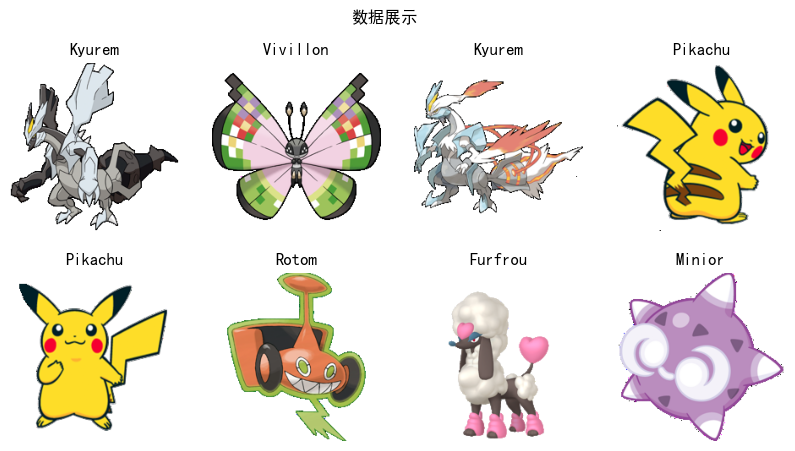

In [8]:
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("数据展示")

images, labels = next(iter(train_loader))

for i in range(8):
    img = images[i].permute(1, 2, 0)
    ax = plt.subplot(2, 4, i + 1)  
    ax.patch.set_facecolor('yellow')
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")        

In [9]:
model = models.resnet152(pretrained=True)
print(model)

d:\Program Files\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program Files\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
params_to_update = model.parameters()
model = model.to(device)
# set optimizer
optimizer = optim.Adam(params_to_update, lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7,
                                      gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [11]:
train_loss_list = []
train_acc_list = []

# start training
for epoch in range(20):
    print('Epoch {}/{}'.format(epoch + 1, 20))
    since = time.time()
    t_loss, t_acc = 0.0, 0.0
    model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        preds = torch.max(outputs, 1)[1]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += loss.item() * inputs.size(0)
        t_acc += torch.sum(preds == labels)

    time_elapsed = time.time() - since
    train_loss = t_loss / len(train_loader.dataset)
    train_acc = t_acc.cpu().numpy() / len(train_loader.dataset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc) 
    print('Time elapsed {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(t_loss / len(train_loader.dataset),
                                                  t_acc / len(train_loader.dataset)))

Epoch 1/20
Time elapsed 0m 8s
Train Loss: 3.0489 Acc: 0.4229
Epoch 2/20
Time elapsed 0m 6s
Train Loss: 1.5801 Acc: 0.4686
Epoch 3/20
Time elapsed 0m 6s
Train Loss: 1.1636 Acc: 0.6343
Epoch 4/20
Time elapsed 0m 6s
Train Loss: 0.7583 Acc: 0.7257
Epoch 5/20
Time elapsed 0m 6s
Train Loss: 0.4788 Acc: 0.8686
Epoch 6/20
Time elapsed 0m 6s
Train Loss: 0.3148 Acc: 0.9086
Epoch 7/20
Time elapsed 0m 6s
Train Loss: 0.2957 Acc: 0.9143
Epoch 8/20
Time elapsed 0m 6s
Train Loss: 0.4998 Acc: 0.8686
Epoch 9/20
Time elapsed 0m 6s
Train Loss: 0.4765 Acc: 0.8686
Epoch 10/20
Time elapsed 0m 6s
Train Loss: 0.2019 Acc: 0.9429
Epoch 11/20
Time elapsed 0m 6s
Train Loss: 0.3622 Acc: 0.8971
Epoch 12/20
Time elapsed 0m 6s
Train Loss: 0.4889 Acc: 0.8343
Epoch 13/20
Time elapsed 0m 6s
Train Loss: 0.3087 Acc: 0.9257
Epoch 14/20
Time elapsed 0m 6s
Train Loss: 0.1214 Acc: 0.9600
Epoch 15/20
Time elapsed 0m 6s
Train Loss: 0.0823 Acc: 0.9714
Epoch 16/20
Time elapsed 0m 6s
Train Loss: 0.0528 Acc: 0.9943
Epoch 17/20
Time 

C:\Users\zhongyanmin\AppData\Local\Temp\ipykernel_15344\781714312.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


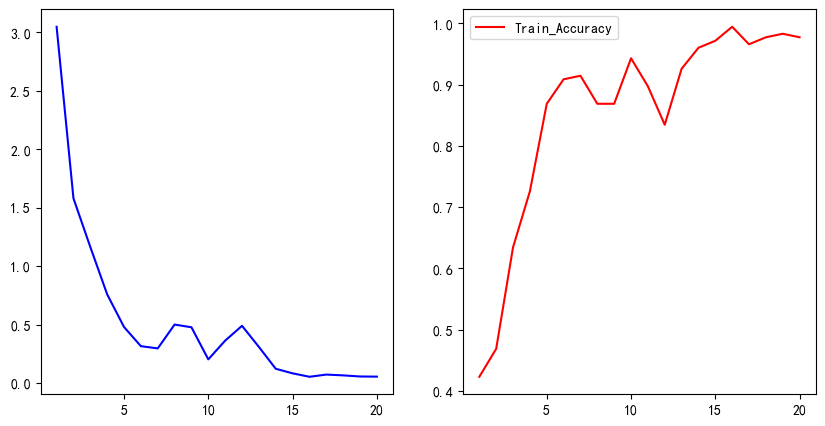

In [12]:
plt.figure(figsize=(10, 5))
plt.title('Train Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('')
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), np.array(train_loss_list), color='blue',
         linestyle='-', label='Train_Loss')
plt.subplot(1, 2, 2)
plt.plot(range(1, 21), np.array(train_acc_list), color='red',
         linestyle='-', label='Train_Accuracy')
plt.legend()  # 凡例
plt.show()  # 表示

In [14]:
# 保存模型
# torch.save(model.state_dict(), 'model/16_model.h5')

# # 加载模型
# new_model = model.load_state_dict(torch.load('model/16_model.h5'))

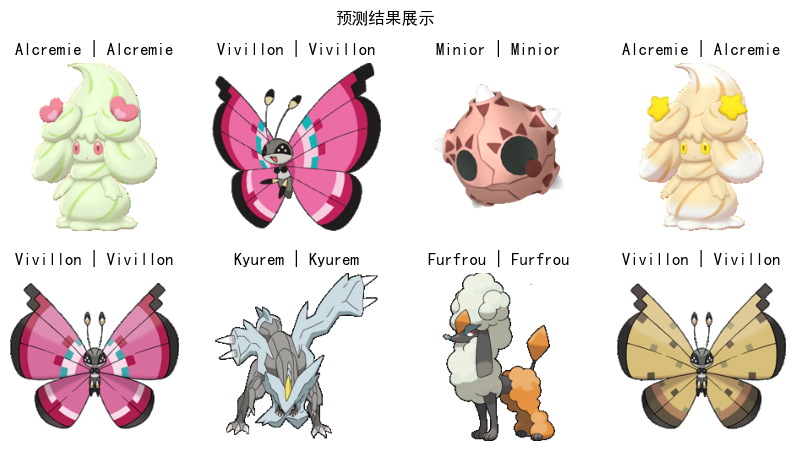

In [35]:
# 采用加载的模型（new_model）来看预测结果
plt.figure(figsize=(10, 5))  # 图形的宽为10高为5
plt.suptitle("预测结果展示")

val_images, val_labels = next(iter(valid_loader))
model.eval()
preds_list = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y = model(inputs)
        preds = y.argmax(1)
        preds_list.append(preds.to('cpu').detach().numpy().copy())
    
for i in range(8):
    img = val_images[i].permute(1, 2, 0)
    ax = plt.subplot(2, 4, i + 1)  
    ax.patch.set_facecolor('yellow')
    plt.imshow(img)
    plt.title(class_names[preds_list[0][i]] + " | " + class_names[val_labels[i]])
    plt.axis("off")